In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,Reshape,Dropout,Flatten,LeakyReLU,BatchNormalization
from IPython import display

In [2]:
#get the data
(x_train,_),_ = tf.keras.datasets.mnist.load_data()
#normalize
x_train = x_train.astype(np.float32)/255.0

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
#define 
LATENT_DIM = 32
BATCH_SIZE = 64

In [4]:
#convert to tf dataset
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(3000)
dataset = dataset.batch(BATCH_SIZE,drop_remainder = True)

In [18]:
#create generator model
def generator():
  model = tf.keras.Sequential()
  model.add(Dense(64,input_shape=[LATENT_DIM]))
  model.add(LeakyReLU(alpha=0.1))
  model.add(BatchNormalization())
  model.add(Dense(128))
  model.add(LeakyReLU(alpha=0.1))
  model.add(BatchNormalization())
  model.add(Dense(28*28,activation="sigmoid"))
  model.add(Reshape([28,28]))
  return model

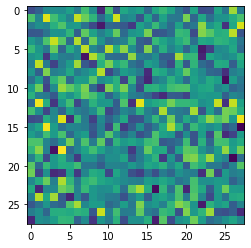

In [19]:
#example generation
latent = tf.random.normal([1,LATENT_DIM])
gen = generator()
plt.imshow(gen(latent)[0,:,:])

In [20]:
#create discriminator model
def discriminator():
  model = tf.keras.Sequential()
  model.add(Flatten(input_shape = [28,28]))
  model.add(Dense(128))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization())
  model.add(Dense(32))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(1,activation="sigmoid"))
  return model

In [21]:
dis = discriminator()

In [22]:
#create composite model
gan = tf.keras.Sequential([gen,dis])

In [23]:
dis.compile(loss="binary_crossentropy",optimizer="Adam")
dis.trainable = False
gan.compile(loss="binary_crossentropy",optimizer="Adam")

In [30]:
def train(gan,dataset,num_epochs):
  gen,dis = gan.layers
  for epoch in range(num_epochs):
    print(epoch)
    for real_image_batch in dataset:
      #draw latent vectors from gaussian prior  
      latent = tf.random.normal([BATCH_SIZE,LATENT_DIM])
      #generate fake images
      fake_image_batch = gen(latent)
      #create input for training discriminator
      x_concat = tf.concat([real_image_batch,fake_image_batch],axis=0)
      y_concat = tf.concat([tf.convert_to_tensor(np.ones(BATCH_SIZE)),tf.convert_to_tensor(np.zeros(BATCH_SIZE))],axis=0)
      dis.trainable = True
      #train the discriminator
      dis.train_on_batch(x_concat,y_concat)
      #fix discriminator weights
      dis.trainable = False
      #again draw latent vectors
      latent = tf.random.normal([BATCH_SIZE,LATENT_DIM])
      #sequence of ones as we want to fool the discriminator
      y = tf.convert_to_tensor(np.ones(BATCH_SIZE))
      #train the generator
      gan.train_on_batch(latent, y)
      #generate example images
      latent = tf.random.normal([1,LATENT_DIM])
      gen = gan.layers[0]
      plt.imshow(gen(latent)[0,:,:])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


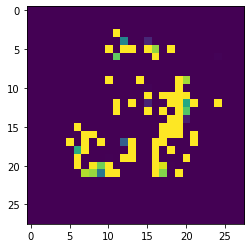

In [38]:
train(gan,dataset,20)

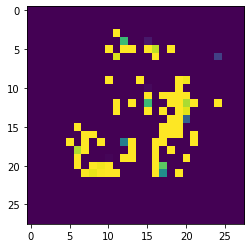

In [39]:
latent = tf.random.normal([1,LATENT_DIM])
gen = gan.layers[0]
plt.imshow(gen(latent)[0,:,:])

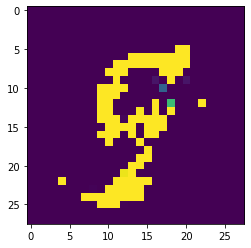

In [40]:
latent = tf.random.normal([1,LATENT_DIM])
gen = gan.layers[0]
plt.imshow(gen(latent)[0,:,:])

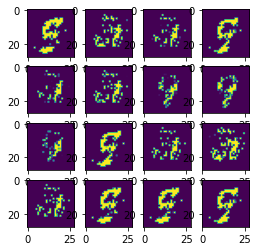

In [41]:
def plot(images):
  #enter a square num of images
  num = np.sqrt(len(images))
  plt.figure(figsize=(num,num))
  for index, image in enumerate(images):
    plt.subplot(num,num,index+1)
    plt.imshow(image)

latent = tf.random.normal([16,LATENT_DIM])
gen = gan.layers[0]
plot(gen(latent))

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
gan.save("/content/drive/MyDrive/BasicGAN_MNIST")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/BasicGAN_MNIST/assets
